# Fine-Tuning a Generative VLM for Image Describing

## Installing dependencies

In [2]:
!pip install -q peft transformers bitsandbytes datasets fsspec==2025.3.0 evaluate pycocoevalcap

In [3]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
from collections import defaultdict
import evaluate
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

2025-05-01 16:41:08.687901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746117668.862338      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746117668.915176      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
df = df.dropna().reset_index(drop=True)
df.to_csv("flickr8k_captions.csv", index=False)

In [5]:
class Flickr8kDataset(Dataset):
    def __init__(self, captions_file, image_dir, processor,max_samples=8000):
      self.image_dir = image_dir
      self.processor = processor
      df = pd.read_csv(captions_file)
      df = df.sample(n=max_samples, random_state=42).reset_index(drop=True)
      self.samples = df
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples.iloc[idx]
        image_path = os.path.join(self.image_dir, row["image"])
        caption = row["caption"]

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Process image
        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        inputs["text"] = caption

        return inputs

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [6]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    device_map="auto",
    load_in_8bit=True
)
# Apply LoRA
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.01,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

trainable params: 2,621,440 || all params: 3,747,301,376 || trainable%: 0.0700


In [7]:
def execute_training_cycle(model, dataloader, optimizer, device, epochs=2):
    model.train()

    for current_epoch in range(epochs):
        epoch_loss = 0.0
        processed_batches = 0

        print(f"\nCommencing training epoch {current_epoch + 1}/{epochs}")

        for batch_idx, data_batch in enumerate(dataloader):
            # Prepare batch data with explicit device placement
            model_inputs = {
                'input_ids': data_batch['input_ids'].to(device),
                'pixel_values': data_batch['pixel_values'].to(device, torch.float16),
                'labels': data_batch['input_ids'].to(device)  # Using input_ids as labels for LM
            }

            # Forward propagation with gradient computation
            model_output = model(**model_inputs)
            batch_loss = model_output.loss

            # Backward pass and optimization
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # Progress tracking
            epoch_loss += batch_loss.item()
            processed_batches += 1

            if batch_idx % 10 == 0:
                avg_loss = epoch_loss / (batch_idx + 1)
                print(f"Epoch {current_epoch + 1} | Batch {batch_idx} | Avg Loss: {avg_loss:.4f} | Current Loss: {batch_loss.item():.4f}")

        # Epoch summary
        epoch_mean_loss = epoch_loss / len(dataloader)
        print(f"\nEpoch {current_epoch + 1} completed")
        print(f"Average epoch loss: {epoch_mean_loss:.4f}")
        print("-" * 50)


In [8]:
# Load dataset
train_dataset = Flickr8kDataset("flickr8k_captions.csv","/kaggle/input/flickr8k/Images", processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
execute_training_cycle(model, train_dataloader, optimizer, device)


Commencing training epoch 1/2


Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


Epoch 1 | Batch 0 | Avg Loss: 6.5234 | Current Loss: 6.5234
Epoch 1 | Batch 10 | Avg Loss: 6.2294 | Current Loss: 6.4492
Epoch 1 | Batch 20 | Avg Loss: 5.8955 | Current Loss: 5.2617
Epoch 1 | Batch 30 | Avg Loss: 5.4697 | Current Loss: 3.8652
Epoch 1 | Batch 40 | Avg Loss: 5.0368 | Current Loss: 3.5371
Epoch 1 | Batch 50 | Avg Loss: 4.6845 | Current Loss: 3.0352
Epoch 1 | Batch 60 | Avg Loss: 4.3669 | Current Loss: 2.4395
Epoch 1 | Batch 70 | Avg Loss: 4.1102 | Current Loss: 2.4570
Epoch 1 | Batch 80 | Avg Loss: 3.8900 | Current Loss: 2.0469
Epoch 1 | Batch 90 | Avg Loss: 3.7088 | Current Loss: 2.4531
Epoch 1 | Batch 100 | Avg Loss: 3.5457 | Current Loss: 2.1426
Epoch 1 | Batch 110 | Avg Loss: 3.4044 | Current Loss: 1.8135
Epoch 1 | Batch 120 | Avg Loss: 3.2827 | Current Loss: 1.8418
Epoch 1 | Batch 130 | Avg Loss: 3.1760 | Current Loss: 1.8711
Epoch 1 | Batch 140 | Avg Loss: 3.0761 | Current Loss: 1.7119
Epoch 1 | Batch 150 | Avg Loss: 2.9934 | Current Loss: 1.8857
Epoch 1 | Batch 160

In [9]:
def generate_caption(image_path):
    """Generate a caption for a single image"""
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to("cuda", torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=50)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

def plot_images_with_captions(image_paths, captions):
    """Plot images with their generated captions"""
    plt.figure(figsize=(20, 12))
    for i, (img_path, caption) in enumerate(zip(image_paths, captions)):
        img = Image.open(img_path)
        plt.subplot(2, 3, i+1)  # 2 rows, 3 columns (for 5 images)
        plt.imshow(img)
        plt.title(caption, wrap=True, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.
Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/acceler

Generated Captions:
2752809449_632cd991b3.jpg: A man and a woman are sitting on a bus .
3097776588_312932e438.jpg: Two men smile at the camera .
1206506157_c7956accd5.jpg: Two dogs are playing in the grass .
1319634306_816f21677f.jpg: A brown dog is sitting on a hillside .
2465218087_fca77998c6.jpg: A man in a yellow kayak stands on the shore of a river .


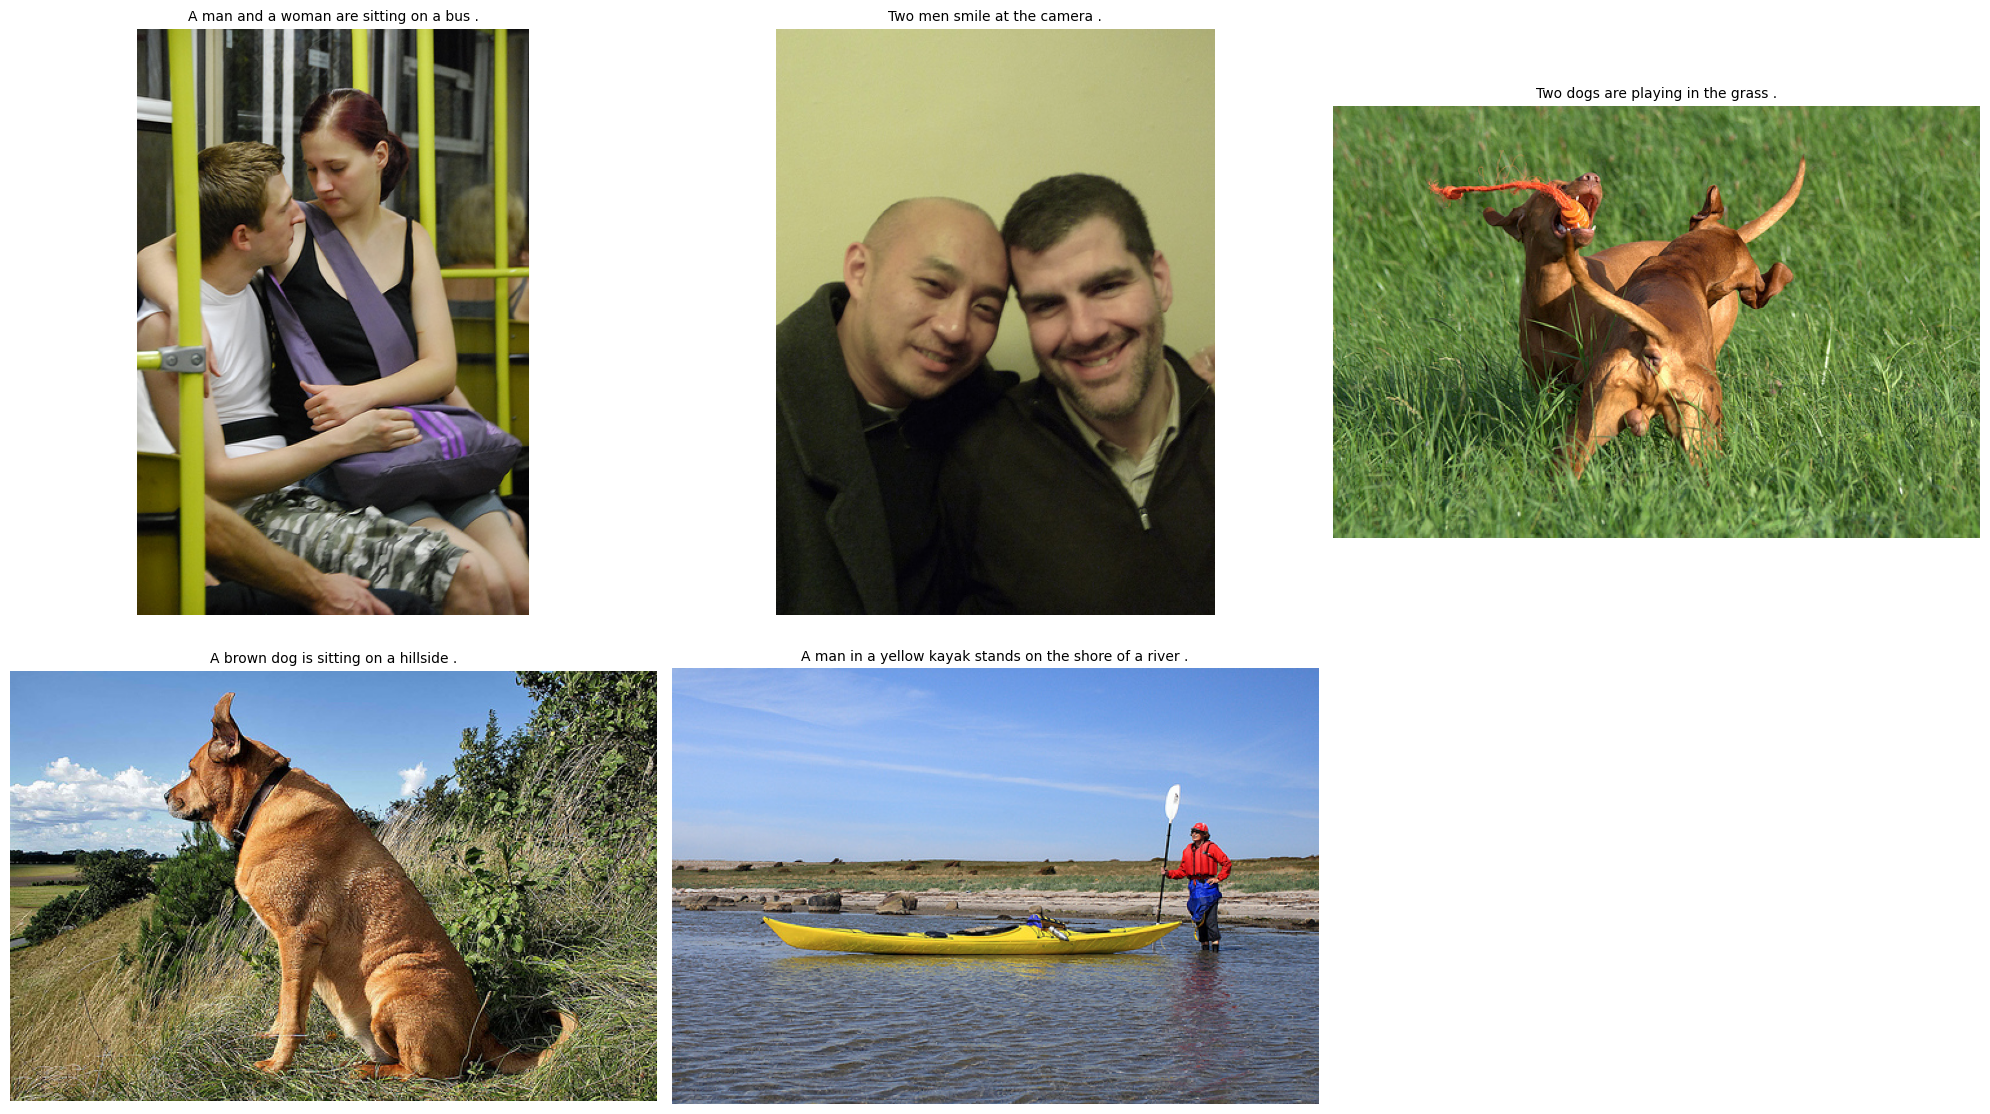

In [10]:
image_dir = "/kaggle/input/flickr8k/Images"
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[5:10]]

# Generate captions
captions = [generate_caption(img_path) for img_path in image_files]

# Display results
print("Generated Captions:")
for img_path, caption in zip(image_files, captions):
    print(f"{os.path.basename(img_path)}: {caption}")

plot_images_with_captions(image_files, captions)

In [11]:
save_path = "/kaggle/working/blip2_finetuned"
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

['/kaggle/working/blip2_finetuned/processor_config.json']

In [12]:
import shutil
import os

# Path to your saved model
save_path = "/kaggle/working/blip2_finetuned"

# Create zip archive
shutil.make_archive(
    base_name="blip2_finetuned_zip",  # Name without extension
    format="zip",                     # Compression format
    root_dir=os.path.dirname(save_path),  # Parent directory
    base_dir=os.path.basename(save_path)  # Folder to zip
)

print(f"Model zipped successfully: {os.path.abspath('blip2_finetuned_zip.zip')}")

Model zipped successfully: /kaggle/working/blip2_finetuned_zip.zip


In [15]:
!pip install -q tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
from tqdm import tqdm

# Initialize metrics
bleu_evaluator = evaluate.load("bleu")
cider_evaluator = Cider()
caption_tokenizer = PTBTokenizer()

# Load dataset and prepare evaluation subset
caption_dataset = pd.read_csv("/kaggle/input/flickr8k/captions.txt",
                            sep=',',
                            names=["image_file", "caption_text"])
evaluation_samples = caption_dataset.iloc[8001:8092].reset_index(drop=True)

# Data storage structures
model_predictions = []
reference_captions = defaultdict(list)
ground_truth_dict = {}
result_dict = {}

# Process images and generate captions
processing_bar = tqdm(evaluation_samples.iterrows(), total=len(evaluation_samples))
for idx, sample in processing_bar:
    # Load and process image
    image_path = os.path.join("/kaggle/input/flickr8k/Images", sample['image_file'])
    input_image = Image.open(image_path).convert('RGB')

    # Generate prediction
    model_input = processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    generated_output = model.generate(pixel_values=model_input.pixel_values,
                                    max_length=25)
    predicted_caption = processor.batch_decode(generated_output,
                                             skip_special_tokens=True)[0].strip()
    model_predictions.append(predicted_caption)

    # Store references
    if sample['image_file'] not in reference_captions:
        reference_captions[sample['image_file']] = caption_dataset[
            caption_dataset['image_file'] == sample['image_file']
        ]['caption_text'].tolist()

    # Prepare CIDEr format
    ground_truth_dict[str(idx)] = [{"caption": cap} for cap in reference_captions[sample['image_file']]]
    result_dict[str(idx)] = [{"caption": predicted_caption}]

processing_bar.close()

# Calculate BLEU score
bleu_score = bleu_evaluator.compute(
    predictions=model_predictions,
    references=[reference_captions[img] for img in evaluation_samples["image_file"]]
)

# Calculate CIDEr score
tokenized_ground_truth = caption_tokenizer.tokenize(ground_truth_dict)
tokenized_results = caption_tokenizer.tokenize(result_dict)
cider_score, _ = cider_evaluator.compute_score(tokenized_ground_truth, tokenized_results)

# Print results
print("\nEvaluation Metrics:")
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print(f"CIDEr Score: {cider_score:.4f}")

100%|██████████| 91/91 [05:02<00:00,  3.32s/it]
PTBTokenizer tokenized 6093 tokens at 47978.50 tokens per second.
PTBTokenizer tokenized 1114 tokens at 13854.29 tokens per second.



Evaluation Metrics:
BLEU Score: 0.3767
CIDEr Score: 1.1191
